In [2]:
import pandas
import matplotlib.pyplot as plt
import pickle
import wntr
import numpy as np
import pandas as pd

import sys
sys.path.append('../Code/')

from testWN import testWN as twm

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration, SpectralClustering
from sklearn.decomposition import PCA

In [3]:
%matplotlib notebook

# Get Network Information

In [4]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
node_names_all = ctown.wn.node_name_list
node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

n_junctions = len(node_names[2])
n_nodes = len(node_names_all)

pump_df = pd.DataFrame(np.ones(len(link_names[0])).reshape(1,-1), columns=link_names[0])
valves_df = pd.DataFrame(np.ones(len(link_names[2])).reshape(1,-1), columns=link_names[2])

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Get Connectivity Matrix

Infos about connectivity matrix [here](https://transportgeography.org/?page_id=6969).

In [5]:
A = np.zeros((n_junctions,n_junctions))
links = ctown.wn.links.todict()
for key in links.keys():
    i = np.where([np.array(node_names[2]) == links[key]['start_node_name']])[1]
    j = np.where([np.array(node_names[2]) == links[key]['end_node_name']])[1]
    
    A[i,j] = 1
    A[j,i] = 1

<IPython.core.display.Javascript object>


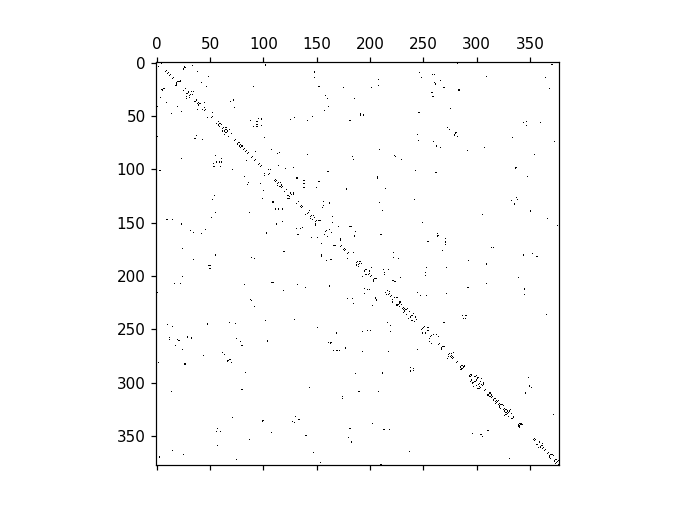

In [6]:
plt.figure()
plt.spy(A)

# Get Coordinates of nodes:

In [8]:
nodes = ctown.wn.nodes.todict()

In [9]:
coords_arr = np.array([nodes[key]['coordinates'] for key in nodes.keys()])
coords = pd.DataFrame(coords_arr, index=node_names_all)

# Clustering

## Prepocess Data:

In [10]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_12_try.pkl'

with open(file, 'rb') as f:
    results=pickle.load(f)

Cross validation file:

In [76]:
file_val = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_40_try.pkl'

with open(file_val, 'rb') as f:
    results_val=pickle.load(f)

In [77]:
press_junctions =results.node['pressure'][node_names[2]]
junction_coords = coords.loc[node_names[2]]

Filter negative and unrealistic values:

In [78]:
#press_junctions = press_junctions[~(press_junctions<0).any(axis=1)]
#press_junctions = press_junctions[~(press_junctions>150).any(axis=1)]

<IPython.core.display.Javascript object>


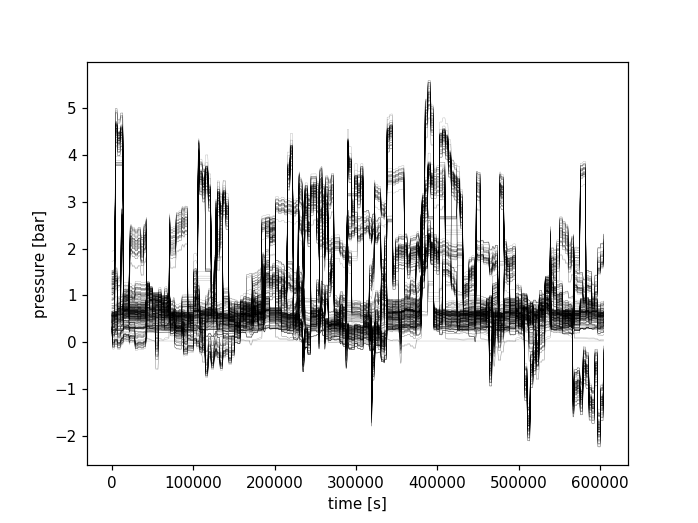

Text(0, 0.5, 'pressure [bar]')

In [79]:
fig, ax = plt.subplots()

ax.plot(press_junctions.index, press_junctions/1e2, color='k', linewidth=0.2, alpha=.4)
ax.set_xlabel('time [s]')
ax.set_ylabel('pressure [bar]')

Normalize Data:

In [80]:
scaling_press = press_junctions.abs().mean()
press_junctions /= scaling_press
scaling_press_df = pd.DataFrame(scaling_press).T
scaling_press_df.index = ['pressure_scaling']

Cluster Settings:

In [81]:
n_clusters = 30

## Pressure Clustering

In [84]:
clustering = FeatureAgglomeration(n_clusters=n_clusters, connectivity=A, linkage='ward').fit(press_junctions.to_numpy())
press_cluster_labels = pd.DataFrame(clustering.labels_.reshape(1,-1), columns=node_names[2], index=['pressure_cluster'])

In [85]:
press_cluster_labels

,J511,J411,J414,J415,J416,J417,J418,J419,J310,J311,...,J287,J288,J289,J300,J301,J302,J304,J306,J307,J317
pressure_cluster,7,6,10,0,0,10,17,17,5,5,...,17,17,17,17,15,15,21,21,15,2


<IPython.core.display.Javascript object>


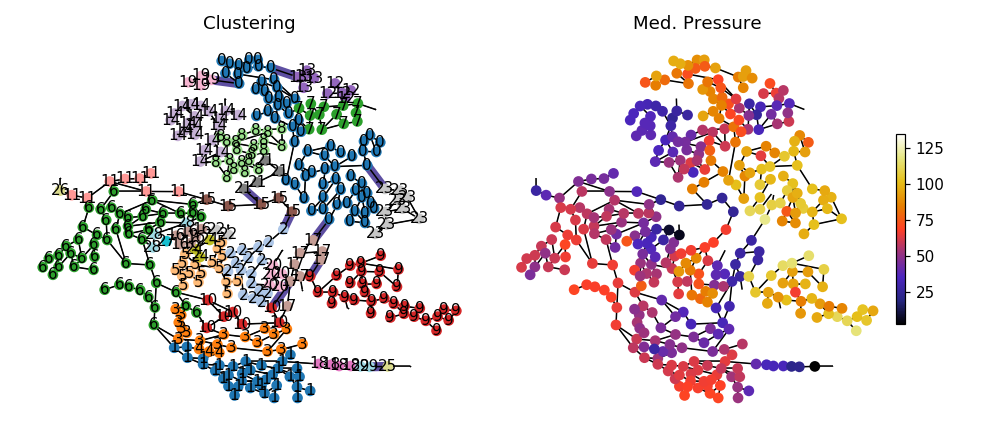

In [19]:
fig_1, ax_1 = plt.subplots(1,2, figsize=(9,4), sharex=True, sharey=True)
press = results.node['pressure']
press_med = press.median()

# Highlight pumps
wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, 
                           add_colorbar=False, title='Pumps', ax=ax_1[0])
# Highlight valves
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, 
                           add_colorbar=False, title='Valves', ax=ax_1[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=press_cluster_labels.loc['pressure'],
                                   node_size=50, node_labels=False, node_cmap='tab20',
                                   add_colorbar=False, title='Clustering', ax=ax_1[0]) 

wntr.graphics.plot_network(ctown.wn, node_attribute=press_med[node_names[2]],node_size=50, 
                           node_cmap='CMRmap', title='Med. Pressure', ax=ax_1[1])  


if False:
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][clustering.labels_==i].mean()
        ax_1[0].text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8), alpha=0.8))
if True:
    for i in range(n_junctions):
        node_loc = coords.loc[node_names[2][i]]
        ax_1[0].text(*node_loc.tolist(), str(clustering.labels_[i]), ha="center", va="center")
    


fig_1.tight_layout()



### Evaluation

In [20]:
# Calculate cluster mean and standard deviation
jun_cl_press_group = press_junctions.groupby(press_cluster_labels.loc['pressure'], axis=1)
jun_cl_press_mean = jun_cl_press_group.mean()
jun_cl_press_std = jun_cl_press_group.std()

<IPython.core.display.Javascript object>


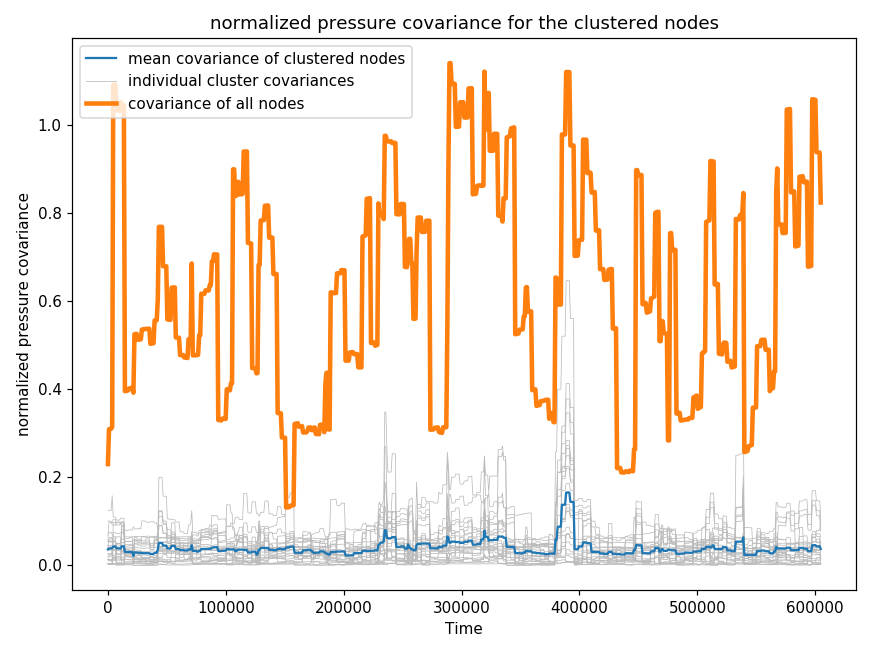

In [21]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

ax_2.plot(jun_cl_press_std, color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_press_std.mean(axis=1), label='mean covariance of clustered nodes')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual cluster covariances')


press_std_ges = press_junctions.std(axis=1)
ax_2.plot(press_std_ges, linewidth=3, label='covariance of all nodes')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('normalized pressure covariance')
ax_2.set_title('normalized pressure covariance for the clustered nodes')

ax_2.legend()
fig_2.tight_layout()   

<IPython.core.display.Javascript object>


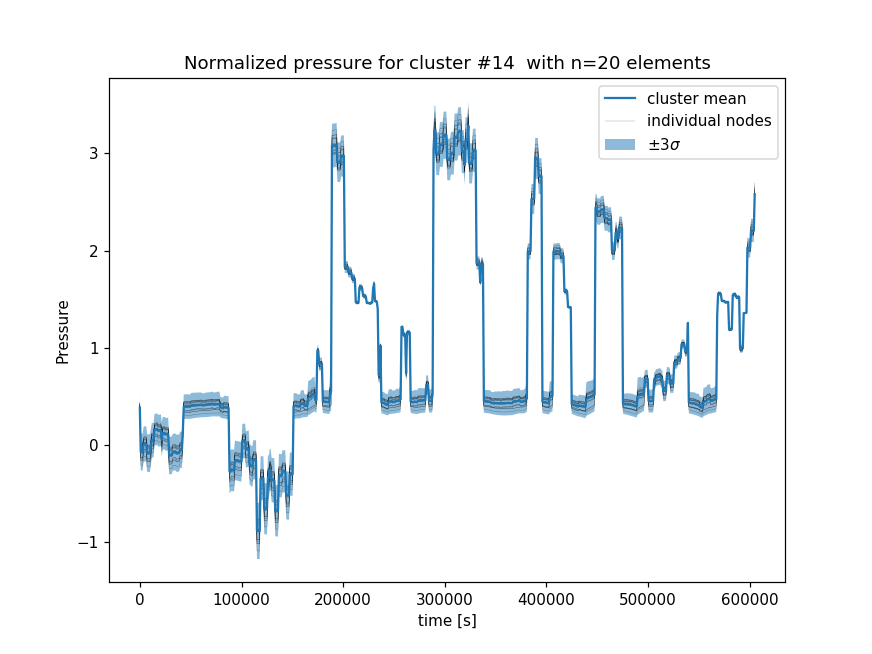

Text(0, 0.5, 'Pressure')

In [26]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

cluster_i=14

ax_2.fill_between(jun_cl_press_mean.index,
                  (jun_cl_press_mean[[cluster_i]]-3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(),
                  (jun_cl_press_mean[[cluster_i]]+3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(), 
                  alpha=0.5, label='$\pm 3\sigma$')
ax_2.plot(jun_cl_press_group.get_group(cluster_i),color='k', linewidth=0.2, alpha=0.5)
ax_2.plot(jun_cl_press_mean[[cluster_i]], label='cluster mean')
ax_2.plot([0,0],[0,0], color='k', linewidth=0.2, alpha=0.5, label='individual nodes')

ax_2.legend()
ax_2.set_title('Normalized pressure for cluster #{}  with n={} elements'.format(cluster_i, jun_cl_press_group.get_group(cluster_i).shape[1]))
ax_2.set_xlabel('time [s]')
ax_2.set_ylabel('Pressure')


## Cross-Validation:

In [34]:
# Get pressure from the validation file
press_junctions_val =results_val.node['pressure'][node_names[2]]
# Apply the same filters as above
#press_junctions_val = press_junctions_val[~(press_junctions_val<0).any(axis=1)]
#press_junctions_val = press_junctions_val[~(press_junctions_val>150).any(axis=1)]
# Scale with the same factors as above
press_junctions_val /= scaling_press
# Calculate cluster mean and standard deviation
jun_cl_press_group_val = press_junctions_val.groupby(press_cluster_labels.loc['pressure'], axis=1)
jun_cl_press_mean_val = jun_cl_press_group_val.mean()
jun_cl_press_std_val = jun_cl_press_group_val.std()

<IPython.core.display.Javascript object>


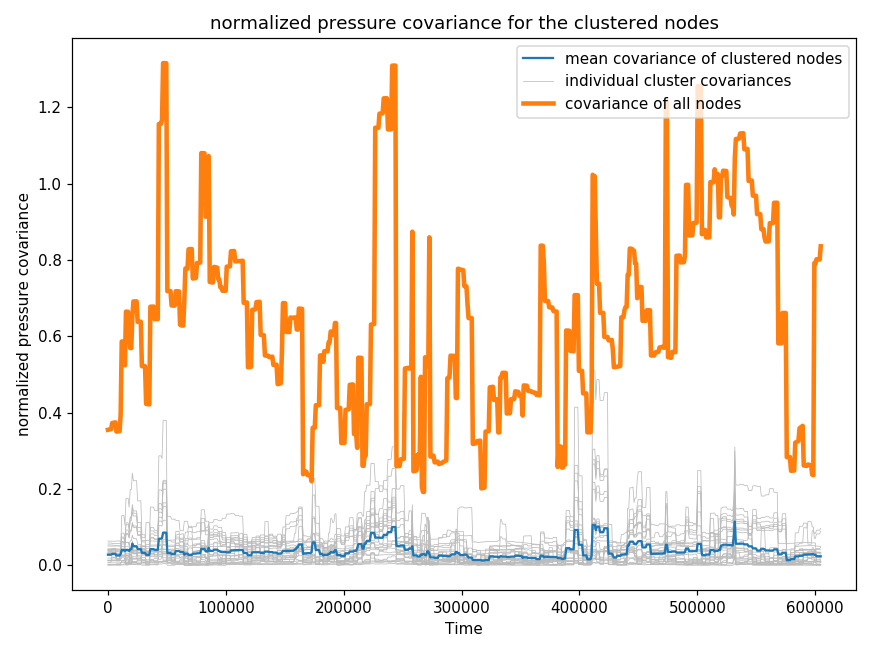

In [35]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

ax_2.plot(jun_cl_press_std_val, color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_press_std_val.mean(axis=1), label='mean covariance of clustered nodes')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual cluster covariances')


press_std_ges_val = press_junctions_val.std(axis=1)
ax_2.plot(press_std_ges_val, linewidth=3, label='covariance of all nodes')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('normalized pressure covariance')
ax_2.set_title('normalized pressure covariance for the clustered nodes')

ax_2.legend()
fig_2.tight_layout()  

<IPython.core.display.Javascript object>


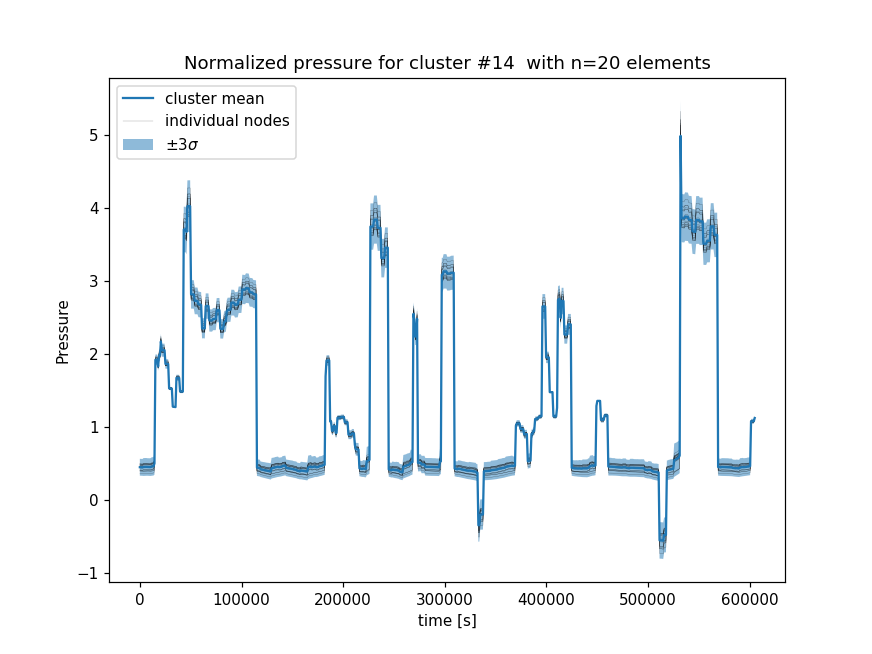

Text(0, 0.5, 'Pressure')

In [36]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

cluster_i=14


ax_2.fill_between(jun_cl_press_mean_val.index,
                  (jun_cl_press_mean_val[[cluster_i]]-3*jun_cl_press_std_val[[cluster_i]]).to_numpy().flatten(),
                  (jun_cl_press_mean_val[[cluster_i]]+3*jun_cl_press_std_val[[cluster_i]]).to_numpy().flatten(), 
                  alpha=0.5, label='$\pm 3\sigma$')
ax_2.plot(jun_cl_press_group_val.get_group(cluster_i),color='k', linewidth=0.2, alpha=0.5)
ax_2.plot(jun_cl_press_mean_val[[cluster_i]], label='cluster mean')
ax_2.plot([0,0],[0,0], color='k', linewidth=0.2, alpha=0.5, label='individual nodes')

ax_2.legend()
ax_2.set_title('Normalized pressure for cluster #{}  with n={} elements'.format(cluster_i, jun_cl_press_group.get_group(cluster_i).shape[1]))
ax_2.set_xlabel('time [s]')
ax_2.set_ylabel('Pressure')

## Quality Clustering

In [37]:
qual_junctions = results.node['quality'][node_names[2]]

<IPython.core.display.Javascript object>


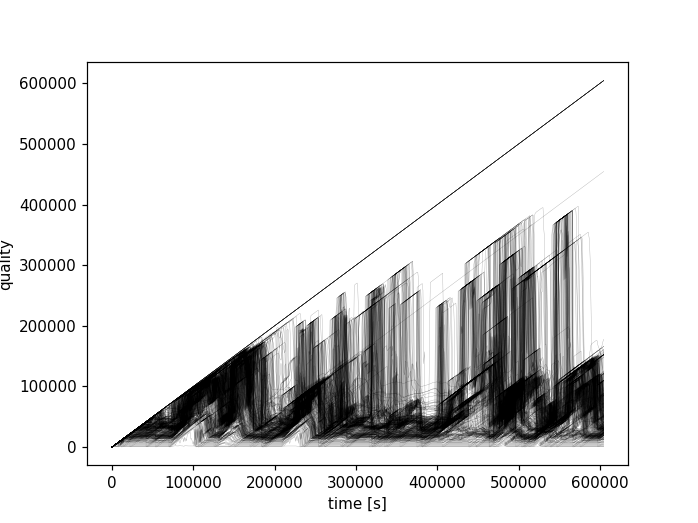

Text(0, 0.5, 'quality')

In [38]:
fig, ax = plt.subplots()

ax.plot(qual_junctions.index, qual_junctions, color='k', linewidth=0.2, alpha=.4)
ax.set_xlabel('time [s]')
ax.set_ylabel('quality')

Normalize Data:

In [39]:
scaling_qual = qual_junctions.mean().mean()
qual_junctions /=  scaling_qual

In [40]:
scaling_qual

71904.68

Cluster Settings:

In [41]:
n_clusters = 30

In [42]:
clustering = FeatureAgglomeration(n_clusters=n_clusters, connectivity=A, linkage='ward').fit(qual_junctions.to_numpy())

qual_cluster_labels = pd.DataFrame(clustering.labels_.reshape(1,-1), 
                                   columns=node_names[2], 
                                   index=['quality'])
cluster_labels = press_cluster_labels.append(qual_cluster_labels)

<IPython.core.display.Javascript object>


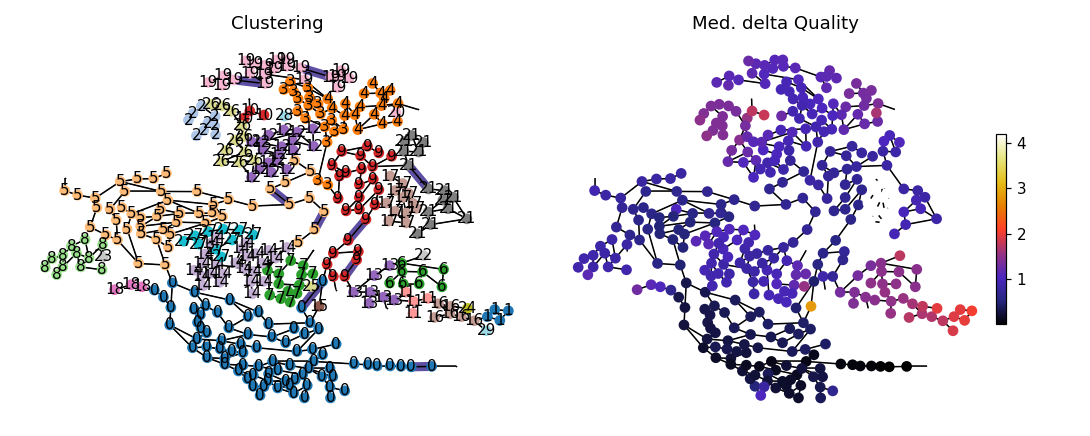

In [43]:
fig_2, ax_2 = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
qual_junctions_mean = qual_junctions.mean()

wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Pumps', ax=ax_2[0])
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Valves', ax=ax_2[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=qual_cluster_labels.loc['quality'],
                                   node_size=50, node_labels=False, node_cmap='tab20',
                                   add_colorbar=False, title='Clustering', ax=ax_2[0])  # clustering
wntr.graphics.plot_network(ctown.wn, node_attribute=qual_junctions_mean,node_size=50, 
                           node_cmap='CMRmap', title='Med. delta Quality', ax=ax_2[1])  # junctions


if False:
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][clustering.labels_==i].mean()
        ax_2[0].text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8), alpha=0.8))
if True:
    for i in range(n_junctions):
        node_loc = coords.loc[node_names[2][i]]
        ax_2[0].text(*node_loc.tolist(), str(clustering.labels_[i]), ha="center", va="center")
    


fig_2.tight_layout()



### Evaluation

In [44]:
# Calculate cluster mean and standard deviation
jun_cl_qual_group = qual_junctions.groupby(cluster_labels.loc['quality'], axis=1)
jun_cl_qual_mean = jun_cl_qual_group.mean()
jun_cl_qual_max = jun_cl_qual_group.max()
jun_cl_qual_max_95 =jun_cl_qual_group.aggregate(lambda arr: np.percentile(arr,axis=1, q=95))
jun_cl_qual_std = jun_cl_qual_group.std()

<IPython.core.display.Javascript object>


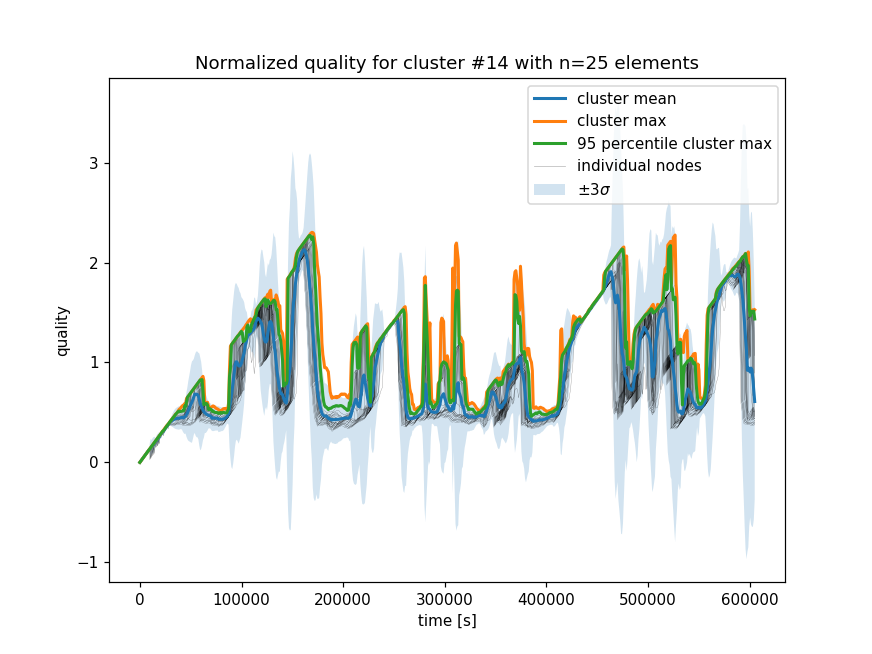

Text(0, 0.5, 'quality')

In [49]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

cluster_i=14

ax_2.fill_between(jun_cl_qual_mean.index,
                  (jun_cl_qual_mean[[cluster_i]]-3*jun_cl_qual_std[[cluster_i]]).to_numpy().flatten(),
                  (jun_cl_qual_mean[[cluster_i]]+3*jun_cl_qual_std[[cluster_i]]).to_numpy().flatten(), 
                  alpha=0.2, label='$\pm 3\sigma$')
ax_2.plot(jun_cl_qual_group.get_group(cluster_i), color='k', linewidth=0.2, alpha=0.5)
ax_2.plot(jun_cl_qual_mean[[cluster_i]], label='cluster mean', linewidth=2)
ax_2.plot(jun_cl_qual_max[[cluster_i]], label='cluster max', linewidth=2)
ax_2.plot(jun_cl_qual_max_95[[cluster_i]], label='95 percentile cluster max', linewidth=2)
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual nodes')

ax_2.legend()
ax_2.set_title('Normalized quality for cluster #{} with n={} elements'.format(cluster_i, jun_cl_qual_group.get_group(cluster_i).shape[1]))
ax_2.set_xlabel('time [s]')
ax_2.set_ylabel('quality')

<IPython.core.display.Javascript object>


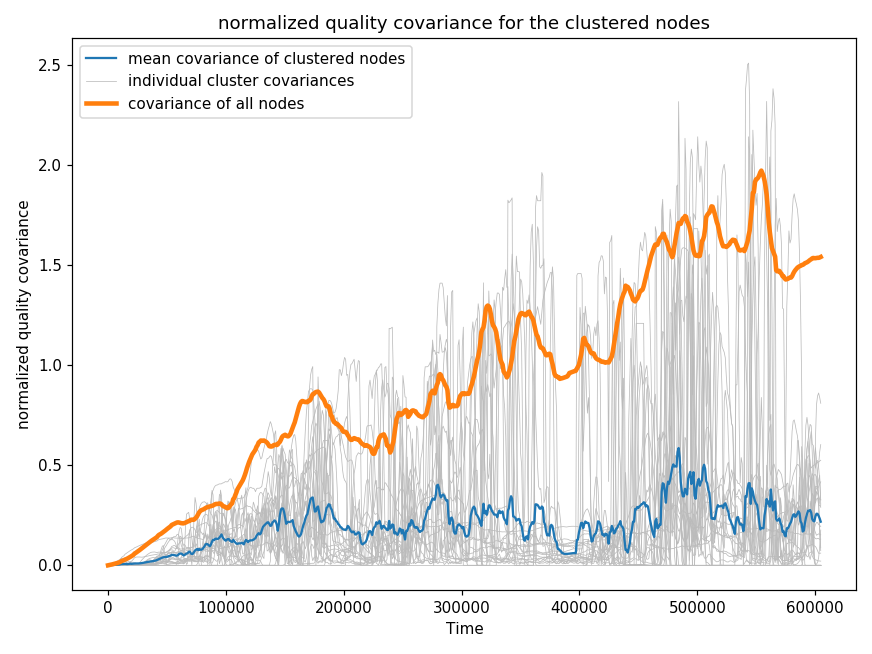

In [50]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

ax_2.plot(jun_cl_qual_std, color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_qual_std.mean(axis=1), label='mean covariance of clustered nodes')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual cluster covariances')


qual_std_ges = qual_junctions.std(axis=1)
ax_2.plot(qual_std_ges, linewidth=3, label='covariance of all nodes')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('normalized quality covariance')
ax_2.set_title('normalized quality covariance for the clustered nodes')

ax_2.legend()
fig_2.tight_layout()  

Export Cluster label

In [86]:
cluster_labels.to_json('cluster_labels.json')
scaling_press_df.to_json('pressure_factor.json')